## Case study bike sharing

Here we experiment with bike sharing data and apply our evaluation framework.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.stats import spearmanr
import json
from scipy.stats import norm
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from libpysal.weights import KNN
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cdist
import wasserstein
import geomloss
from scipy.stats import pearsonr
from esda.moran import Moran
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen

from geoemd.loss.partial_ot import PartialOT
from geoemd.loss.moransi import MoransiLoss

import torch
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size":15})



def compute_pot(cost_matrix, pred_vals, real_vals, phi=0):
    ot_obj = PartialOT(cost_matrix, compute_exact=True, normalize_c=False, penalty_unb=phi)
    return ot_obj( torch.from_numpy(pred_vals).unsqueeze(0),
                   torch.from_numpy(real_vals).unsqueeze(0))
from geoemd.loss.moransi import MoransiLoss


### Set up P, Q and Moran's I

In [28]:
# Euclidean cost matrix
stations = pd.read_csv(os.path.join("..", "data_submission", "data_raw", "bikes_stations.csv"))
station_coords = stations.sort_values("station_id")[["x", "y"]].values
cost_matrix = cdist(station_coords, station_coords)
cost_matrix = cost_matrix / np.max(cost_matrix)

# moransi
moransi_obj = MoransiLoss(cost_matrix)

### Compute MSE, Moran's I and POT

In [3]:
center = np.mean(station_coords, axis=0)
dist_from_center = np.linalg.norm(station_coords - center, axis=1)

In [4]:
import ot
all_dfs = []
for result_path in [os.path.join("..", "data_submission", "predictions", "predictions_bike_sharing_nhits.csv")]:
    bike_result = pd.read_csv(result_path)
    
    res_dict_list = []
    for steps_ahead in bike_result["steps_ahead"].unique():
        for val_sample_ind in bike_result["val_sample_ind"].unique():
            res_dict = {"Sample": val_sample_ind, "steps_ahead": steps_ahead}
            single_res_ot = bike_result[(bike_result["steps_ahead"] == steps_ahead) & (bike_result["val_sample_ind"] == val_sample_ind)].sort_values("group")

            # compute T
            pred_vals = single_res_ot["pred"].values
            real_vals = single_res_ot["gt"].values
            ot_dist = compute_pot(cost_matrix, pred_vals, real_vals)
            res_dict["OT"] = ot_dist
            residuals = torch.from_numpy(pred_vals - real_vals)
            res_dict["MSE"] = np.mean((pred_vals - real_vals)**2)
            res_dict["MAE"] = np.mean(np.abs(pred_vals - real_vals))
            res_dict["total_error"] = np.abs(np.sum(pred_vals) - np.sum(real_vals))
            res_dict["distance_from_center"] = np.mean(dist_from_center * ((pred_vals - real_vals)**2))
        
            res_dict["moransi"] = moransi_obj(
                torch.from_numpy(pred_vals).unsqueeze(0), torch.from_numpy(real_vals).unsqueeze(0)
            ).item()
            #  moransi_normed(residuals, weight_matrix).item()
            res_dict_list.append(res_dict)
    print("Number of samples", len(res_dict_list))
    res_dict_list = pd.DataFrame(res_dict_list)
    all_dfs.append(res_dict_list)
all_dfs = pd.concat(all_dfs)

Number of samples 500


In [5]:
# clean: rmv outliers
three_std_above = all_dfs["OT"].mean() + all_dfs["OT"].std() * 3
all_dfs_clean = all_dfs[all_dfs["OT"] <= three_std_above]

In [6]:
print(pearsonr(all_dfs_clean["MSE"], all_dfs_clean["moransi"]))

PearsonRResult(statistic=-0.7073702411422833, pvalue=2.6367286594693737e-76)


In [7]:
import sklearn
import statsmodels.api as sm
normalized_df = (all_dfs_clean-all_dfs_clean.mean())/all_dfs_clean.std()
x = normalized_df[["MSE", "moransi"]]
y = normalized_df["OT"]
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     OT   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     335.7
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           1.14e-92
Time:                        17:14:43   Log-Likelihood:                -488.88
No. Observations:                 495   AIC:                             983.8
Df Residuals:                     492   BIC:                             996.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.021e-17      0.029   3.08e-15      1.0

PearsonRResult(statistic=0.37577854906998, pvalue=4.768513023188679e-18)


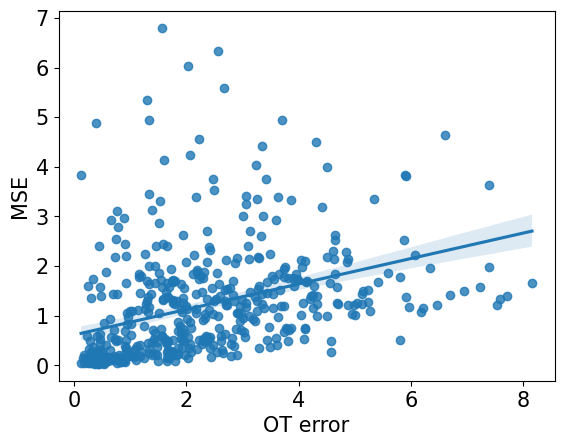

PearsonRResult(statistic=0.20084976123090517, pvalue=6.69069592988524e-06)


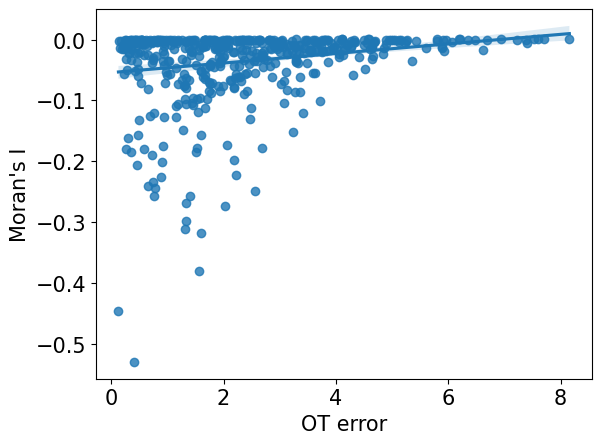

In [9]:
for m, lab in zip(["MSE", "moransi"], ["MSE", "Moran's I"]):
    print(pearsonr(all_dfs_clean["OT"], all_dfs_clean[m]))

    sns.regplot(data=all_dfs_clean, x="OT", y=m)
    plt.ylabel(lab)
    plt.xlabel("OT error")
    # plt.savefig(f"figures/regplot_{lab}.pdf")
    plt.show()

### Spatial plot of transport costs

The stations were randomly subsampled, thus, the plot is not perfectly reproducible.

**NOTES**
* Use Euclidean distance
* Using partial OT with \phi=0

In [11]:
penalty_waste = 0
NUM = len(cost_matrix) // 3

inds = np.sort(np.random.permutation(len(stations))[:NUM])
euclidean_cost = cdist(station_coords, station_coords)
cost_matrix = (euclidean_cost[inds])[:, inds]
cost_matrix = cost_matrix / 1000

clen, cwid = cost_matrix.shape
extended_cost_matrix = np.zeros((clen + 1, cwid + 1))
extended_cost_matrix[:clen, :cwid] = cost_matrix
extended_cost_matrix[clen, :] = penalty_waste
extended_cost_matrix[:, cwid] = penalty_waste

station_coords_sel = station_coords[inds]

# moransi
moransi_obj = MoransiLoss(cost_matrix)

In [12]:
def get_normed_vals(single_res_ot):
    pred_vals_normed = single_res_ot["pred"].values
    gt_vals = single_res_ot["gt"].values
    gt_vals_normed = gt_vals / np.sum(gt_vals) * np.sum(pred_vals_normed)
    return pred_vals_normed, gt_vals_normed

def get_extended_vals(single_res_ot):
    y_pred = torch.from_numpy(single_res_ot["pred"].values)
    # get corresponding ground truth df
    y_true = torch.from_numpy(single_res_ot["gt"].values)
    diff = (torch.sum(y_pred) - torch.sum(y_true)).unsqueeze(0)
    diff_pos = torch.relu(diff)
    diff_neg = torch.relu(diff * -1)
    # extend
    extended_pred = torch.cat((y_pred, diff_neg), dim=-1)
    extended_true = torch.cat((y_true, diff_pos), dim=-1)
    return extended_pred.numpy(), extended_true.numpy()

In [13]:
res_mse = bike_result.copy()
np.random.seed(2)
for val_sample_ind in np.random.permutation(res_mse["val_sample_ind"].unique()):
    single_res_mse = res_mse[(res_mse["steps_ahead"] == 2) & (res_mse["val_sample_ind"] == val_sample_ind)].sort_values("group")
    if abs(single_res_mse["gt"].sum() - single_res_mse["pred"].sum()) > single_res_mse["gt"].sum()//3:
        print(single_res_mse["gt"].sum(), single_res_mse["pred"].sum())
        continue
        
    print(single_res_mse["gt"].sum(), single_res_mse["pred"].sum())
    
    single_res_mse = single_res_mse.iloc[inds]

    pred_vals_normed, gt_vals_normed = get_extended_vals(single_res_mse)
    T_mse = ot.emd(pred_vals_normed, gt_vals_normed, extended_cost_matrix)
    break

41.0 62.20167503943617
212.0 205.21531565059072


In [14]:
error = T_mse * extended_cost_matrix
np.sum(error)

33.060383135714446

In [15]:
start_station_id, end_station_id = np.where(T_mse[:-1, :-1] > 0)

In [16]:
start_coords, end_coords = station_coords_sel[start_station_id], station_coords_sel[end_station_id]

In [17]:
errors = np.abs(pred_vals_normed - gt_vals_normed)[:-1]
residuals = (pred_vals_normed - gt_vals_normed)[:-1]
def get_col(val):
    if val < 0: 
        return "purple" # one col for correct, one for over, one for under estimation
    elif val == 0: 
        return "green"
    else: 
        return "orange"
cols = [get_col(val) for val in residuals]
labels = [map(c, {"green": "correct", "orange": "Prediction > GT", "purple": "GT > Prediction"}) for c in cols]

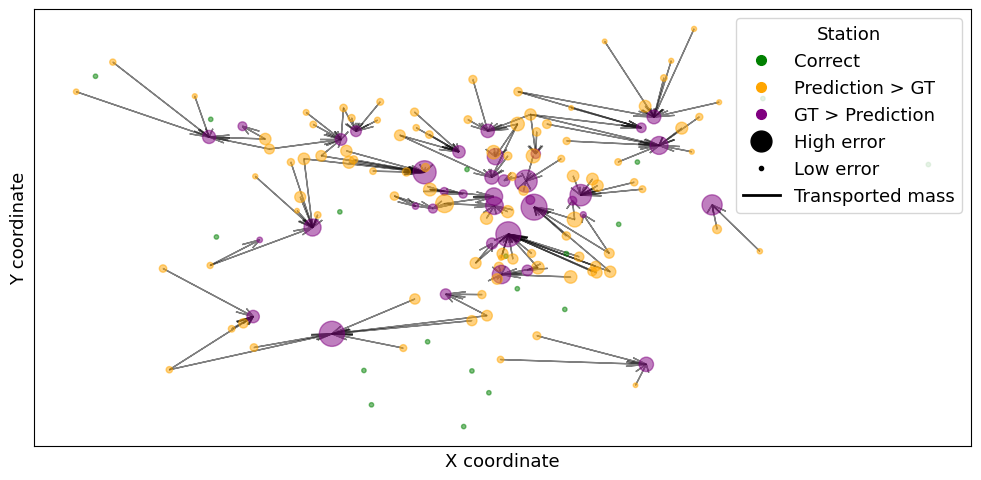

In [18]:
from matplotlib.lines import Line2D
plt.rcParams.update({"font.size":13})

fix, ax = plt.subplots(figsize=(10,5))
for (x1, y1), (x2, y2) in zip(start_coords, end_coords):
    plt.arrow(x1, y1, x2-x1, y2-y1, head_width=200, length_includes_head=True, overhang=1, alpha=0.5)
plt.scatter(station_coords_sel[:, 0], station_coords_sel[:, 1], s=errors*100+10, c=cols, alpha=0.5) # , label=labels)
plt.xticks([])
plt.yticks([])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
legend_elements = [Line2D([0], [0], marker='o', color='green', lw=0, markerfacecolor='g', markersize=7, label='Correct'),
                   Line2D([0], [0], marker='o', color='orange',lw=0, label='Prediction > GT', markerfacecolor='orange', markersize=7),
                   Line2D([0], [0], marker='o', color='purple',lw=0, label='GT > Prediction', markerfacecolor='purple', markersize=7),
                   Line2D([0], [0], marker='o', color='black',lw=0, label='High error', markerfacecolor='black', markersize=15),
                   Line2D([0], [0], marker='o', color='black',lw=0, label='Low error', markerfacecolor='black', markersize=3),
                   Line2D([0], [0], color='black',lw=2, label='Transported mass')
]

# Create the figure
ax.legend(handles=legend_elements, title="Station") # , loc='center')
plt.tight_layout()
# plt.savefig("figures/bikes_transport_plot.pdf")
plt.show()

## Plot cost matrix and relation to map-matched cost

In [25]:
# Map-matched cost matrix
c1 = pd.read_csv(os.path.join("..", "data_submission", "dist_matrix_mapmatched.csv")).set_index("station_id").values / 1000
for i in range(len(c1)):
    c1[i,i] = 0
fill_value_cost = 15
c1[c1 < 0] = fill_value_cost

In [26]:
# Euclidean cost matrix
stations = pd.read_csv(os.path.join("..", "data_submission", "data_raw", "bikes_stations.csv"))
station_coords = stations.sort_values("station_id")[["x", "y"]].values
c2 = cdist(station_coords, station_coords) / 1000

In [27]:
bike_result = pd.read_csv(os.path.join("..", "data_submission", "predictions", "predictions_bike_sharing_nhits.csv"))

In [22]:
import ot
res_dict_list = []
for val_sample_ind in bike_result["val_sample_ind"].unique():
    res_dict = {"Sample": val_sample_ind}
    for cost_matrix, c_name in zip([c1, c2], ["map-matched cost", "Euclidean distance"]):
        single_res_ot = bike_result[(bike_result["steps_ahead"] == 2) & (bike_result["val_sample_ind"] == val_sample_ind)].sort_values("group")
    
        # compute T
        # pred_vals_normed, gt_vals_normed = get_normed_vals(single_res_ot)
        pred_vals = single_res_ot["pred"].values
        real_vals = single_res_ot["gt"].values
        ot_dist = compute_pot(cost_matrix, pred_vals, real_vals)
        res_dict[f"OT ({c_name})"] = ot_dist
    res_dict_list.append(res_dict)
res_dict_list = pd.DataFrame(res_dict_list)

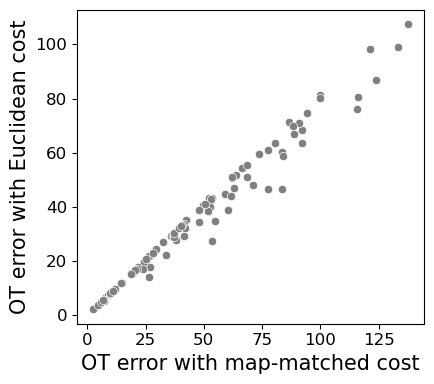

In [23]:
plt.rcParams.update({"font.size": 12})
plt.figure(figsize=(4.5,4))
sns.scatterplot(y=res_dict_list["OT (Euclidean distance)"], x=res_dict_list["OT (map-matched cost)"],  c="gray") # label=r"$E_{POT}$",
plt.ylabel(r"OT error with Euclidean cost", fontsize=15)
plt.xlabel(r"OT error with map-matched cost", fontsize=15)
plt.tight_layout()
# plt.savefig("figures/mapmatched.pdf")
plt.show()

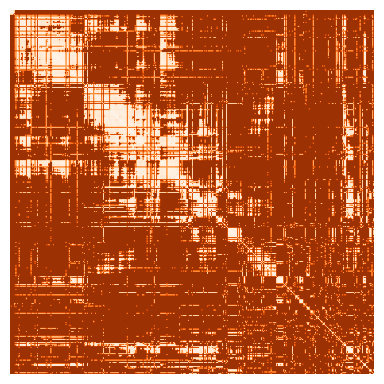

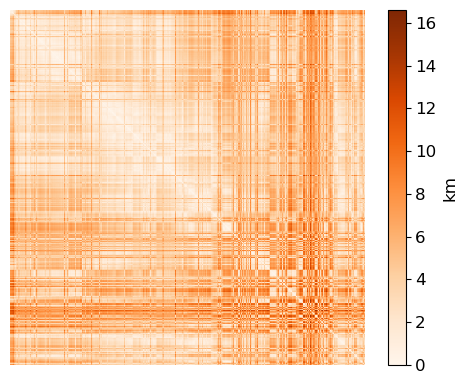

In [24]:
cmap = "Oranges"
plt.figure(figsize=(4,4))
plt.imshow(c1, vmax=c2.max(), cmap=cmap)
plt.axis("off")
plt.tight_layout()
# plt.savefig("figures/cost_matrix_mapmatched.pdf")
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(c2, cmap=cmap)
plt.colorbar(label="km")
plt.axis("off")
plt.tight_layout()
# plt.savefig("figures/cost_matrix_eucl.pdf")
plt.show()